In [1]:
# WHAT is this? LOVED. COME ON! !@#! get rid of punctuations
# Contraction words I've = I have
# removal of stop words
# removal of numbers

import contractions
import emoji
import string 
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


# change to lower_case
def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
  
  regex = re.compile('[^a-zA-Z0-9]')
  #first parameter is the replacement, second parameter is your input string
  new_review = regex.sub(' ', review);
  return new_review

# Remove numbers, we choose to remove numbers is because we find that for instance a review is descrbing about something "the 2 girls in the book is so cute"
# it could lead to 2 star review. Because we realize that, those negative reviews user, will include numbers in their reviews.
# Example: I give 2 star is because, the book is completely no link, also the words used in the book have a lot of grammatical error
# As classification is supervised learning model, it is trained by using the corpus with respect to the (sentiment category). Thus, 
# if the number 2 appear even in a positive comment, it may in the end up in the negative comment depending on how strong the number 2 in the corpus is.
# Thus, this will make the predictions go wrong. To reduce confusion for the model to learn, we decided to remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

# Remove extra whitespaces
def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

# We dont want to remove words that are from the whitelist, the reason is because it can have better meaning in our sentences
# The reason why i dont want remove one two three four etc is because, for instance if a user comment One start, this could mean it is a negative review straight away
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    whitelist = ["not", "no", "cannot", "do", "must", "should", "would", "could"]
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:] 

In [2]:

# Feel free to include others preprocessing tehcnique that you want, like lemmatization etc.
# -----------------------------------------------------------------------------------------
# The main function to clean text
def clean_text(path):
    data = pd.read_csv(path)
    
    data['reviewDescription'] = data['reviewDescription'].apply(lower_case)
    data['reviewDescription'] = data['reviewDescription'].apply(change_contractions)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_emojis)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_punctuations)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_numbers)
    
    return data

In [3]:
train_annotated_df = pd.read_csv('../train_data_polarity.csv')
validation_annotated_df = pd.read_csv("../validation_data_polarity.csv")
test_annotated_df = pd.read_csv('../test_annotated.csv')
train_annotated_df.head()

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,Polarity
0,0,451524934,4,Clear why this is a classic,One person found this helpful,A remarkable book. I sometimes hesitate to rea...,True,humor_entertainment,1
1,1,670062510,5,Read it. It's worth it.,NaN,All of my kids had to read this and watch the ...,True,children,1
2,2,1542046599,5,DEFINITELY read this,NaN,I am a big fan of books from each characters v...,True,mystery,1
3,3,1542046599,1,This Book Is Awful,One person found this helpful,"The story was convoluted, repetitive and borin...",True,mystery,-1
4,4,399587683,5,This story was too cute!!!,NaN,"I think I loved this book as much as ""The Wedd...",True,romance,1


In [4]:
# Rename unnamed columns to index. 
train_annotated_df = train_annotated_df.rename(columns={"Unnamed: 0":"Index"})
validation_annotated_df = validation_annotated_df.rename(columns={"Unnamed: 0":"Index"})
test_annotated_df = test_annotated_df.rename(columns={"Unnamed: 0":"Index"})

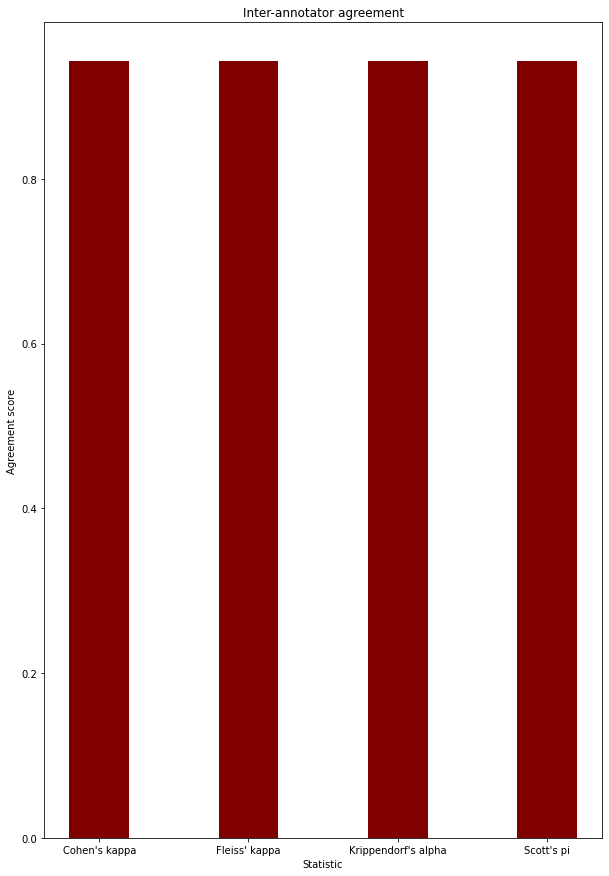

In [5]:
test_annotated_dataset = test_annotated_df
# Inter-annotator agreement 
from nltk import agreement
import matplotlib.pyplot as plt

annotator_1 = test_annotated_dataset["Annotator_1"].to_numpy()
annotator_2 = test_annotated_dataset["Annotator_2"].to_numpy()
annotator_3 = test_annotated_dataset["Annotator_3"].to_numpy()

taskdata=[[0,str(i),str(annotator_1[i])] for i in range(0,len(annotator_1))]+[[1,str(i),str(annotator_2[i])] for i in range(0,len(annotator_2))]+[[2,str(i),str(annotator_3[i])] for i in range(0,len(annotator_3))]
ratingtask = agreement.AnnotationTask(data=taskdata)

cohen_kappa = ratingtask.kappa()
fleiss_kappa = ratingtask.multi_kappa()
krippendorf_alpha = ratingtask.alpha()
scotts_pi = ratingtask.pi()

scores = {"Cohen's kappa": cohen_kappa, "Fleiss' kappa": fleiss_kappa, "Krippendorf's alpha": krippendorf_alpha, "Scott's pi" : scotts_pi}

statistic = list(scores.keys())
values = list(scores.values())

fig = plt.figure(figsize = (10, 15))
plt.bar(statistic, values, color ='maroon',
        width = 0.4)
plt.xlabel("Statistic")
plt.ylabel("Agreement score")
plt.title("Inter-annotator agreement")
plt.show()

